In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import scipy.stats as stats
# Import data processing package
from DataProcessing import *
# Import plot packages
import gspplot
from gspplot import *
# Import graph packages
import gsp
from pygsp import graphs, filters, plotting, utils
# Import other packages
from Learning import *
from operator import itemgetter
import warnings; warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and Crop a Patch

In [2]:
path_cloud = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud      = load_cloud(path_cloud)
newcloud   = cloud_preprocess(cloud)
# Crop a patch from cloud
patch      = crop_patch(newcloud, (150, 300), (150, 300))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 300], y:[150, 300].
=> Points left for patch: 157488.
----------------------------------------------------


## 1.2 Data Visualization

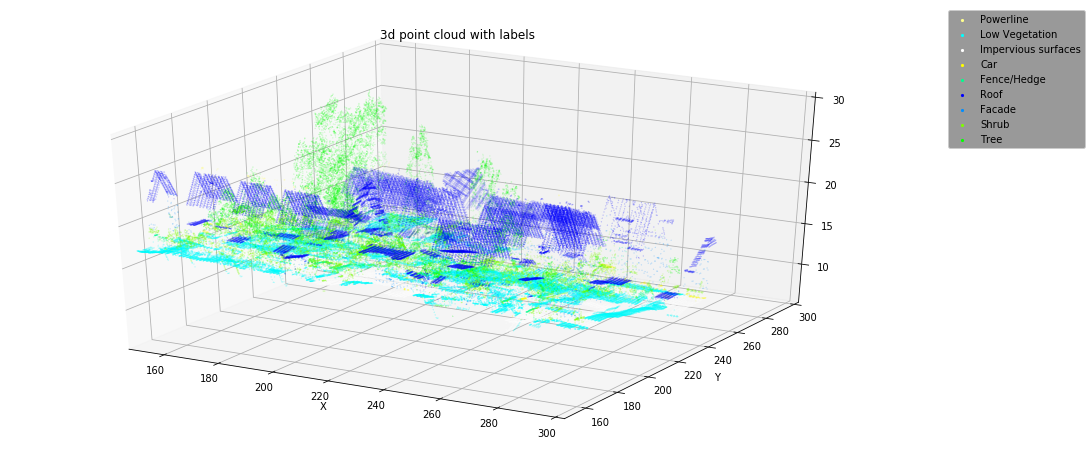

In [3]:
plot_graph_3D(patch, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(150, 300), 
              yRange=(150, 300))

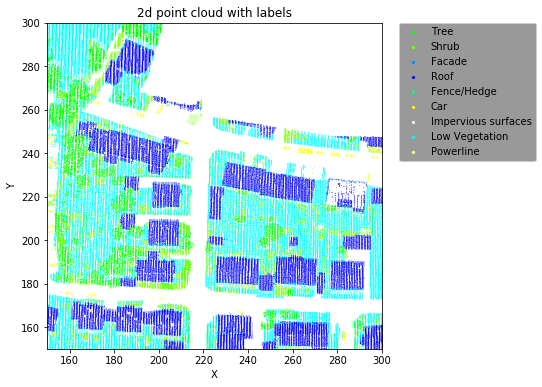

In [4]:
plot_graph_2D(patch, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(150, 300), 
              yRange=(150, 300))

Here, we find that there blue roofs are overlapped by some powerline points. This can bring a bad effect when setting the ground truth.

# 2 Graph Construction 

## 2.1 Generating Graph

Five types of graph are generated in the following way:  
1) When type is '30nn', connect 30 nearest neighbors of a particular node.  
2) When type is 'r101', connect neighbors within the radius of 1.1.  

Then, it remains to calculate the weights:  
1) Gaussian: Use Euclidean distance. Weight is calculated by: $$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{2\sigma^2} \right)$$  
Where $\sigma$ is the mean value of all distances.

2) Binary: Set all weights to be 1 if connected.

3) Local: Comparing to Gaussian, only $\sigma$ changes here.$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma_i \sigma_j} \right)$$  
Where $\sigma_i$ is the distance between node i and its farthest neighbor, the same for node j.



### Use the Number of Neighbors

In [5]:
# 30nn, Gaussian kernel
G_30nn_Gaussain = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='distance', neightype='number', lap_type='combinatorial')
# 30nn, Binary graph
G_30nn_Binary   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='connectivity', neightype='number', lap_type='combinatorial')
# 30nn, Local scaling
G_30nn_Local    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='local', neightype='number', lap_type='combinatorial')

### Use the Radius to Find Neighbors

In [6]:
# r1.1, Gassian kernel
G_r101_Gaussain = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                mode='distance', neightype='radius', lap_type='combinatorial')
# r1.1, Binary graph
G_r101_Binary   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                mode='connectivity', neightype='radius', lap_type='combinatorial')

## 2.2  Gaussian Kernel Visualization

In [7]:
# Compute a list of distances 
_, dists1  = gsp.knn_w(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                       mode='distance', neightype='number')
_, dists2  = gsp.knn_w(cloud=patch[['x', 'y', 'z']], r=1.1, dist3D=False, 
                       mode='distance', neightype='radius')

# Compute minimum and maximum distance with neighbors
dists1, dists2 = np.array(dists1), np.array(dists2)
s1, s2         = np.mean(dists1[dists1!=0]), np.mean(dists2[dists2!=0])
d_max1, d_max2 = np.max(dists1), 1.1
d_min1, d_min2 = np.min(dists1), np.min(dists1)

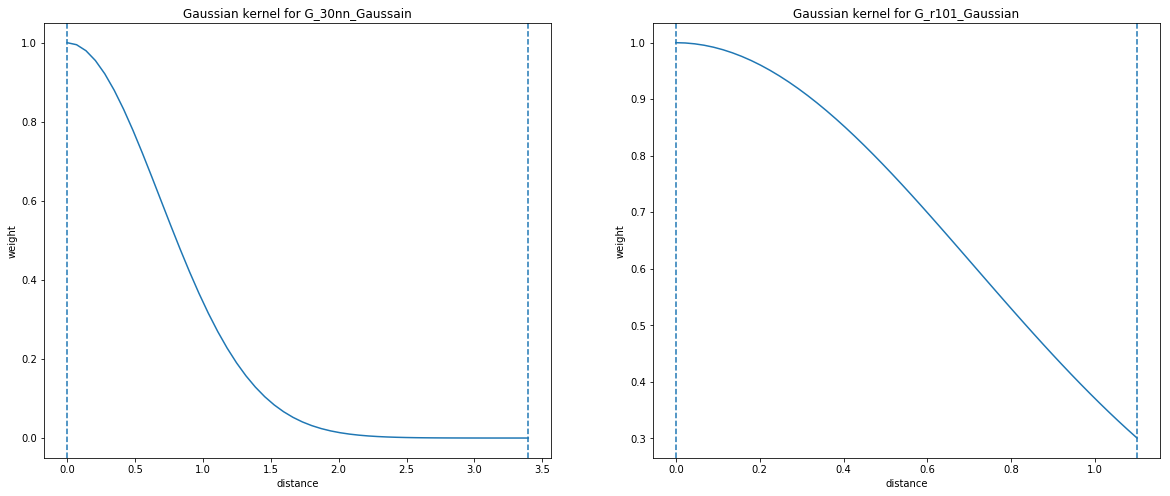

In [8]:
# Visualize weights wrt distance of different kernels
fig = plt.figure(figsize=(20, 8))

# Gaussian kernel with 30 nearest neighbours
ax1 = fig.add_subplot(121)
x1 = np.linspace(d_min1, d_max1, 50)
y1 = s1*np.sqrt(2*np.pi)*stats.norm.pdf(x1, 0, s1)
ax1.plot(x1, y1)
ax1.set_xlabel('distance')
ax1.set_ylabel('weight')
ax1.axvline(x=d_min1, linestyle='--')
ax1.axvline(x=d_max1, linestyle='--')
ax1.set_title("Gaussian kernel for G_30nn_Gaussain")

# Gaussian kernel with radius 1.1
ax2 = fig.add_subplot(122)
x2 = np.linspace(d_min1, d_max2, 50)
y2 = s2*np.sqrt(2*np.pi)*stats.norm.pdf(x2, 0, s2)
ax2.plot(x2, y2)
ax2.set_xlabel('distance')
ax2.set_ylabel('weight')
ax2.axvline(x=d_min2, linestyle='--')
ax2.axvline(x=d_max2, linestyle='--')
ax2.set_title("Gaussian kernel for G_r101_Gaussian")

plt.show()

# 3 POI detection

## 3.1 Mexican Hat Filter Construction

In [9]:
# Create graph dictionary
graph_list = [G_30nn_Gaussain, G_30nn_Binary, G_30nn_Local,
              G_r101_Gaussain, G_r101_Binary]

# Initialize filters dictionary
filter_key = ['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local', 
              'g_MH_r101_Gaussain', 'g_MH_r101_Binary']

filter_dict = dict.fromkeys(filter_key)
for i, idx in zip(filter_dict.keys(), range(5)):
    if 'nn' in i:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([0.04]), lpfactor=1, scales=[0.04])
    else:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([0.01]), lpfactor=1, scales=[0.01])

## 3.2 Visualization Filters

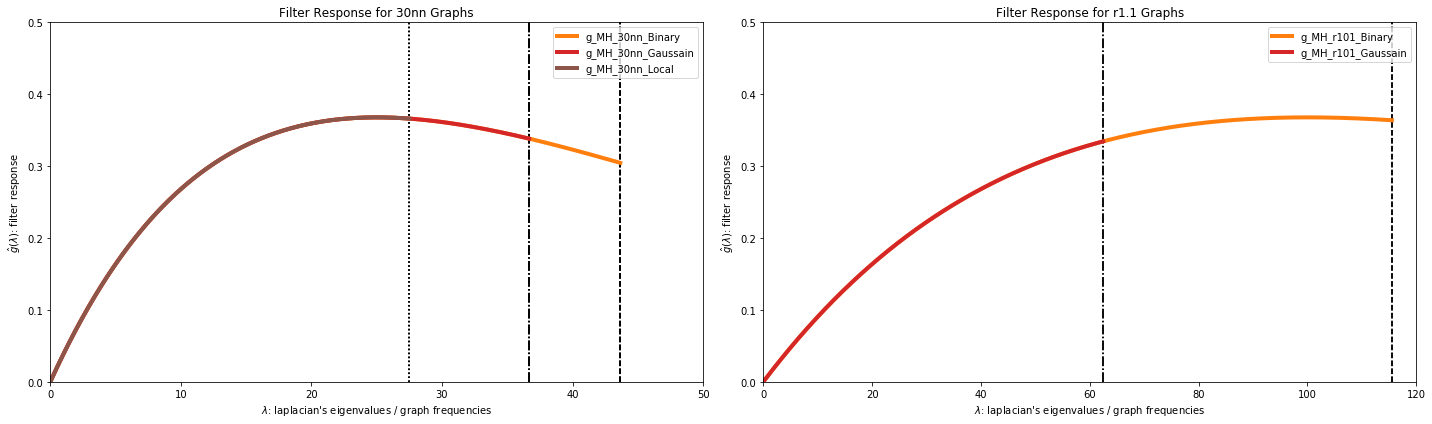

In [10]:
fig = plt.figure(figsize=(20, 6))

# Visualize filters constructed using number of Neighbors
ax1 = fig.add_subplot(121)
for i,j in zip(itemgetter(*[1, 0, 2])(list(filter_dict.keys())), range(3)):
    filter_dict[i].plot(ax=ax1, show_sum=False)
    ax1.lines.pop(j)
    ax1.set_xlim(0, 50)
    ax1.set_ylim(0, 0.5)
    ax1.vlines(G_30nn_Binary.lmax, 0, 0.5, 'k', '--')
    ax1.vlines(G_30nn_Gaussain.lmax, 0, 0.5, 'k', '-.')
    ax1.vlines(G_30nn_Local.lmax, 0, 0.5, 'k', ':')
    ax1.set_title("Filter Response for 30nn Graphs")
    ax1.legend(itemgetter(*[1, 0, 2])(list(filter_dict.keys())))

# Visualize filters constructed using radius to Find Neighbors
ax2 = fig.add_subplot(122)
for i,j in zip(itemgetter(*[4, 3])(list(filter_dict.keys())), range(2)):
    filter_dict[i].plot(ax=ax2, show_sum=False)
    ax2.lines.pop(j)
    ax2.set_xlim(0, 120)
    ax2.set_ylim(0, 0.5)
    ax2.vlines(G_r101_Binary.lmax, 0, 0.5, 'k', '--')
    ax2.vlines(G_r101_Gaussain.lmax, 0, 0.5, 'k', '-.')
    ax2.set_title("Filter Response for r1.1 Graphs")
    ax2.legend(itemgetter(*[4, 3])(list(filter_dict.keys())))
plt.tight_layout()

plt.show()

## 3.3 POI Detection and Visualization

In [11]:
threshold_nn, threshold_r = 0.2, 0.1

# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_30nn_Binary', 's_30nn_Local',
                             's_r101_Gaussain', 's_r101_Binary'])

# Create edge index dictonary, highlight nodes that have high frequency
edge_dict   = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                             'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i, j, k in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys()):
    signal_dict[i] = filter_dict[j].filter(patch.z, method = 'chebyshev')
    if 'nn' in i:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_nn
    else:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_r

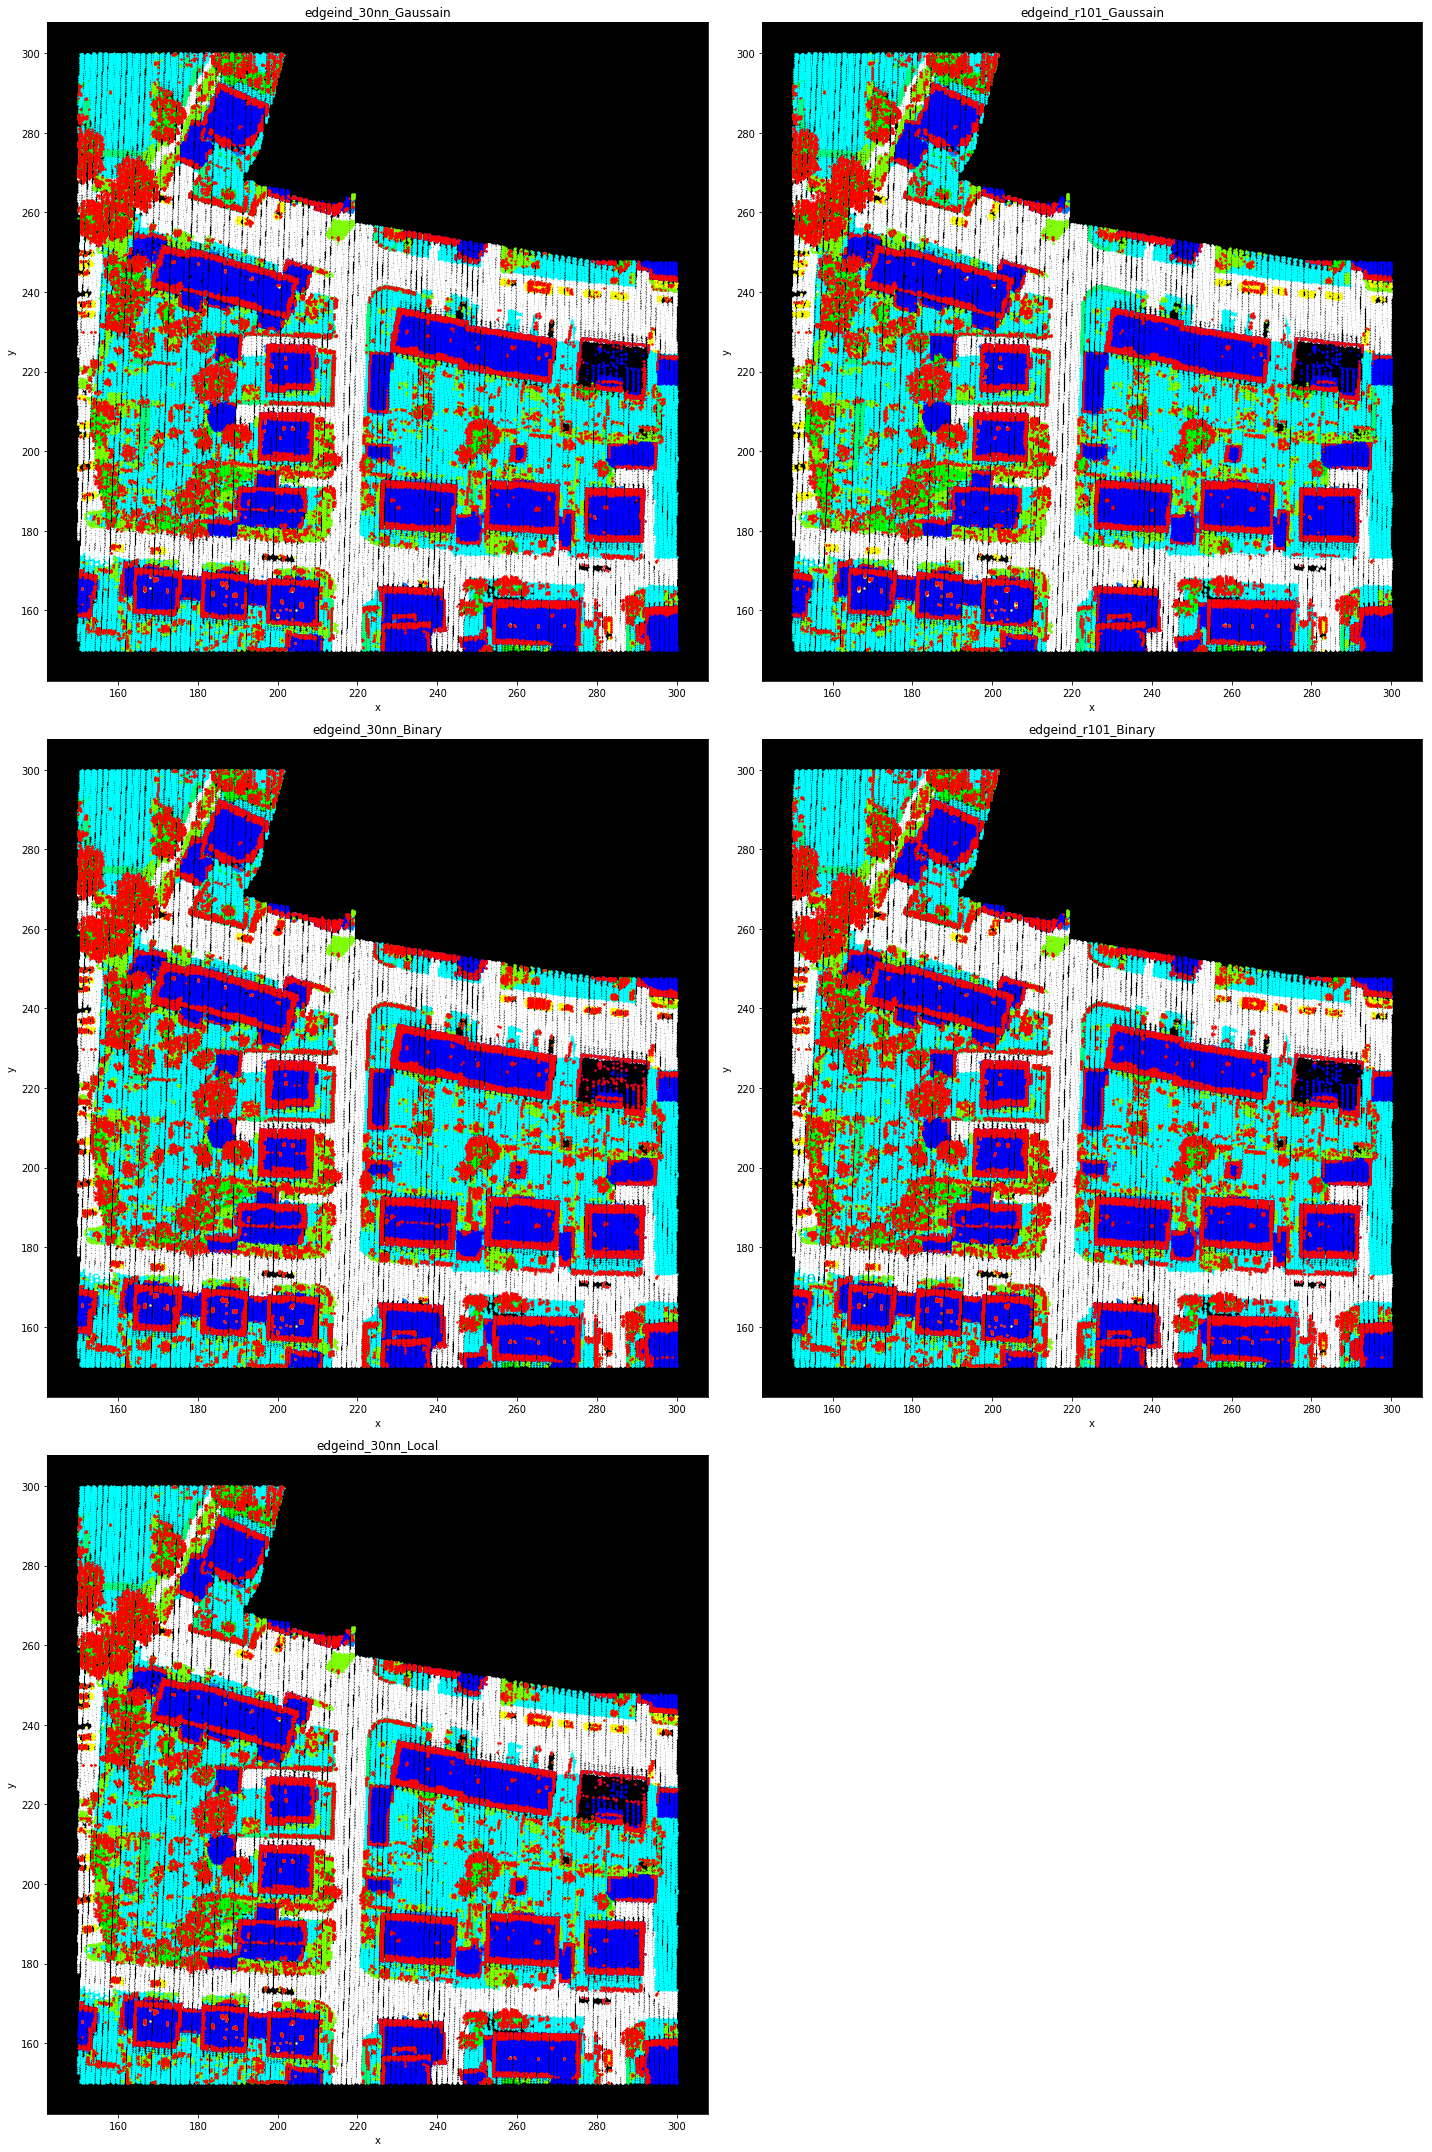

In [12]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,30))
axes = []
for i in range(5):
    axes.append(plt.subplot2grid((3,2), (i%3, int(i/3)), colspan=1))
for i, j in zip(edge_dict.keys(), axes):               
    if 'nn' in i:
        gspplot.plot_vaihingen_2D(patch, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j, 
                                  label_high='Edges',
                                  title="{}".format(i))
    else:
        gspplot.plot_vaihingen_2D(patch, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j, 
                                  label_high='Edges',
                                  title="{}".format(i))
plt.tight_layout()

## 3.4 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

It is noticed that some points in the body of the buildings come out. They seem to surround the powerline points. So I do the following procedures: 1) If the nodes belong to roofs or powerlines, set the signal to be 1. 2) Remove the positive false points after filtering the signal. We cannot delete those powerline points in the dataframe because the indices are changed in this way.

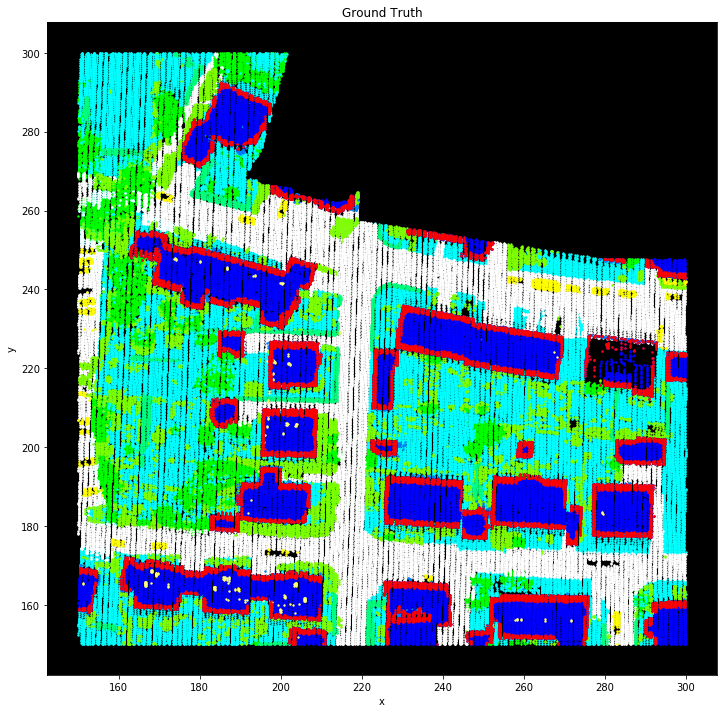

In [13]:
df2, edge_roof = set_ground_truth(patch=patch, threshold=0.08, f=filter_dict['g_MH_30nn_Binary'], figsize=(12, 12))

## 3.5 Graph Quantitative Comparison

The table below shows what the highlighted points are composed of in each type of the graph. The column named total calculte the total number of points that come out after filtering in each graph representation. Other columns like precision and recall are calculated in the following way:

Precision = $\frac{detected\ points\ \cap \ GT}{detected\ points}$  
Recall (refer to ground truth) = $\frac{detected\ points\ \cap \ GT}{GT}$  
Recall (refer to label) = $\frac{detected\ points\ \cap \ roof points}{roof\ points}$

In [14]:
df = comp_df(patch, edge_dict, labels=labels, normalize=True)
qua_comp_df(df, df2, edge_dict, edge_roof)

,Powerline,Low Vegetation,Impervious surfaces,Car,Fence/Hedge,Roof,Facade,Shrub,Tree,Total,Precision,Recall_GT,Recall_roof
30nn_Binary,0.006137,0.017379,0.001580,0.020296,0.051773,0.425880,0.011059,0.146234,0.319661,32913,0.288184,0.837232,0.379125
r101_Binary,0.006415,0.022136,0.001683,0.015911,0.050116,0.394925,0.012958,0.161622,0.334233,31487,0.293010,0.814370,0.336336
30nn_Local,0.006905,0.015307,0.001607,0.016549,0.042670,0.407957,0.013919,0.146787,0.348299,27373,0.325503,0.786477,0.302039
30nn_Gaussain,0.007153,0.013928,0.001476,0.012225,0.040952,0.413724,0.013588,0.141819,0.355134,26421,0.332463,0.775355,0.295656
r101_Gaussain,0.006970,0.009818,0.001148,0.006630,0.031408,0.425432,0.015385,0.124782,0.378427,23529,0.351481,0.729985,0.270745


The Precision column seems to give the completely opposite conclusion compared to the Recall_GT column. That is, when the Recall_GT rate is higher, we have less precision. This may seems a little confusing at first look. But when we look at the total points each type of graph has detected, we find that more points in total tend to leads to less precision. That explain this phenomenon.